In [35]:
import json
from collections import Counter

import transformers
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline
import seaborn as sns

fm.get_fontconfig_fonts()
font_location = '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf'
font_name = fm.FontProperties(fname=font_location, size=12).get_name()

## 데이터 분포 파악

### WoS Domain

In [5]:
train_data_dir = "/opt/ml/input/data/train_dataset"
ontology_file = os.path.join(train_data_dir, "ontology.json")
slot_meta_file = os.path.join(train_data_dir, "slot_meta.json")
dial_file = os.path.join(train_data_dir, "train_dials.json")

In [31]:

slot_meta = json.load(open(slot_meta_file))
domain_list = [val.split('-')[0] for val in slot_meta]
domain_count = Counter(domain_list)
print(domain_count)

Counter({'숙소': 15, '식당': 13, '관광': 9, '택시': 5, '지하철': 3})


<AxesSubplot:title={'center':'도메인 별 slot 종류수'}>

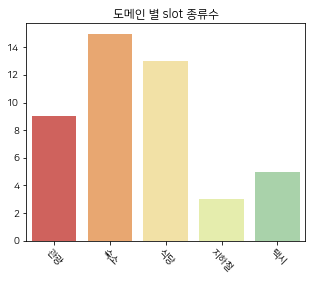

In [38]:
plt.rcParams['figure.figsize'] = [5, 4]
plt.rc('font', family=font_name)

sns.set_palette("Spectral")

plt.xticks(rotation = -45)
plt.rcParams['figure.figsize'] = [5, 4]
plt.rc('font', family=font_name)

sns.set_palette("Spectral")

plt.xticks(rotation = -45)
plt.title("도메인 별 slot 종류수")
sns.barplot(x=list(domain_count.keys()), y=list(domain_count.values()))

각 domain 별로 어떤 slot 으로 이루어져 있는지 확인

In [43]:
from collections import defaultdict
slot_per_domain = defaultdict(list)
print(len(slot_meta))
for val in slot_meta:
    slot_per_domain[val.split('-')[0]].append(val.split('-')[1])
slot_per_domain


45


defaultdict(list,
            {'관광': ['경치 좋은',
              '교육적',
              '도보 가능',
              '문화 예술',
              '역사적',
              '이름',
              '종류',
              '주차 가능',
              '지역'],
             '숙소': ['가격대',
              '도보 가능',
              '수영장 유무',
              '스파 유무',
              '예약 기간',
              '예약 명수',
              '예약 요일',
              '이름',
              '인터넷 가능',
              '조식 가능',
              '종류',
              '주차 가능',
              '지역',
              '헬스장 유무',
              '흡연 가능'],
             '식당': ['가격대',
              '도보 가능',
              '야외석 유무',
              '예약 명수',
              '예약 시간',
              '예약 요일',
              '이름',
              '인터넷 가능',
              '종류',
              '주류 판매',
              '주차 가능',
              '지역',
              '흡연 가능'],
             '지하철': ['도착지', '출발 시간', '출발지'],
             '택시': ['도착 시간', '도착지', '종류', '출발 시간', '출발지']})

<AxesSubplot:title={'center':'Slot 별 가능한 값의 수'}>

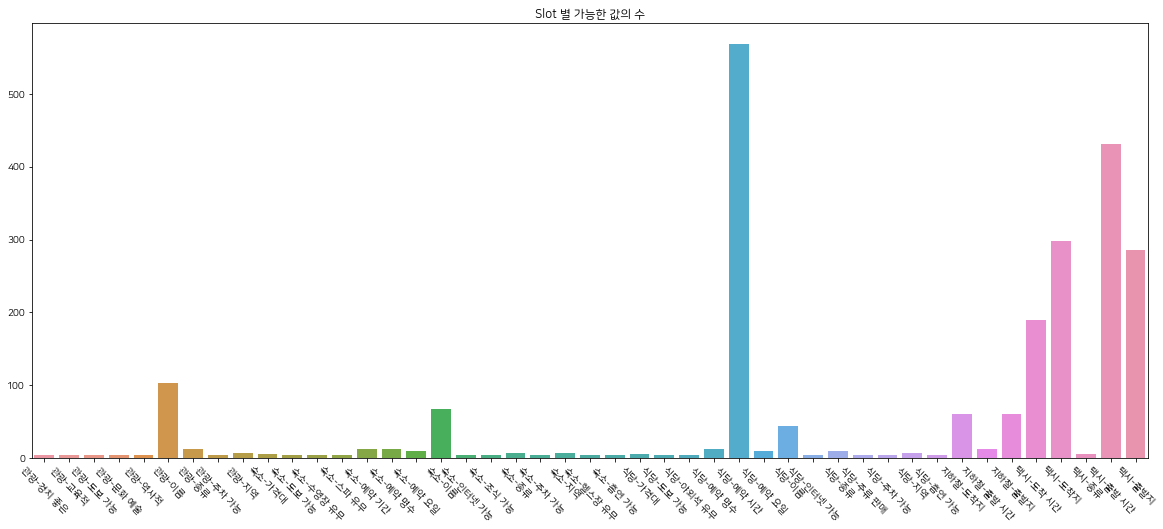

In [57]:
ontology_list = json.load(open(ontology_file))
slot_value_counts = defaultdict(int)
for slot, val_list in ontology_list.items():
    slot_value_counts[slot] = len(val_list)
slot_value_counts

plt.rcParams['figure.figsize'] = [20, 8]
plt.rc('font', family=font_name)

sns.set_palette("Spectral")

plt.xticks(rotation = -45)
plt.rcParams['figure.figsize'] = [5, 4]
plt.rc('font', family=font_name)

sns.set_palette("Spectral")

plt.xticks(rotation = -45)
plt.xticks(rotation = -45)
plt.rcParams['figure.figsize'] = [5, 4]
plt.rc('font', family=font_name)

sns.set_palette("Spectral")

plt.xticks(rotation = -45)
plt.xticks(rotation = -45)
plt.rcParams['figure.figsize'] = [5, 4]
plt.rc('font', family=font_name)

sns.set_palette("Spectral")

plt.xticks(rotation = -45)
plt.title("Slot 별 가능한 값의 수")
sns.barplot(x=list(slot_value_counts.keys()), y=list(slot_value_counts.values()))

# Dialogue 분석

In [85]:
train_dials = json.load(open(dial_file))

dial_per_domains = defaultdict(list)
def user_utterance_per_domain(train_dials):
    for train_dial in train_dials:
        domains = train_dial["domains"]
        for dial in train_dial["dialogue"]:
            if dial["role"] == "sys": continue
            else:
                for domain in domains:
                    dial_per_domains[domain].append(dial["text"])
user_utterance_per_domain(train_dials)




In [86]:
dial_per_domains.keys()

dict_keys(['관광', '식당', '지하철', '택시', '숙소'])

## Bigram, Trigram 만들고 분석하기

### 단어 단위

In [101]:
import re

def clarify_text(text):
    text = re.sub("[\.\?\!\#]", ' ', text)
    return text
print(clarify_text('서울에서 !!#?경치?가 좋은 관광지가... 어디가 있나요?'))
print(dial_per_domains.keys())
for key, val in dial_per_domains.items():
    dial_per_domains[key] = list(map(clarify_text, val))
# print(dial_per_domains.keys())
# print(dial_per_domains['관광'])


def make_word_ngram(n_grams, domain_text_data):
    ngrams_per_domain = defaultdict(list)
    for domain, texts in domain_text_data.items():
        for text in texts:
            word_list = [word for word in text.split(' ') if word]
            ngrams_per_domain[domain].extend(zip(*[word_list[i:] for i in range(n_grams)]))
    return ngrams_per_domain

bigrams_per_domain = make_word_ngram(2, dial_per_domains)
trigrams_per_domain = make_word_ngram(3, dial_per_domains)
print(bigrams_per_domain['관광'][0])
print(trigrams_per_domain['관광'][0])

서울에서     경치 가 좋은 관광지가    어디가 있나요 
dict_keys(['관광', '식당', '지하철', '택시', '숙소'])
('서울', '중앙에')
('서울', '중앙에', '있는')


In [130]:
print(len(bigrams_per_domain['관광']))
print(len(set(bigrams_per_domain['관광'])))
bigram_domain1_count = Counter(bigrams_per_domain['관광'])
bigram_sorted = sorted(list(bigram_domain1_count.keys()), key=lambda x: -bigram_domain1_count[x])
i = 0
for i, bigram in enumerate(bigram_sorted):
    if bigram_domain1_count[bigram] < 100 or i >= 20:
        break
    print(bigram, bigram_domain1_count[bigram])

188767
74025
('어떻게', '되나요') 859
('서울', '중앙에') 683
('안녕하세요', '서울') 665
('서울', '북쪽에') 648
('좀', '알려주세요') 629
('수', '있나요') 485
('네', '감사합니다') 466
('같은', '지역에') 462
('저', '그리고') 457
('그리고', '서울') 453
('네', '알겠습니다') 448
('적당한', '가격대의') 444
('아', '네') 443
('서울', '남쪽에') 421
('서울', '서쪽에') 403
('알아봐', '주세요') 367
('서울', '동쪽에') 356
('확인', '감사합니다') 350
('알', '수') 347
('수', '있을까요') 346
20


In [ ]:

def plot_top_grams(domain_grams, top_k):
    gram_count = Counter(domain_grams)
    gram_sorted = sorted(list(gram_count.keys()), key=lambda x: -gram_count[x])
    for i, gram in enumerate(gram_sorted):
        

    if bigram_domain1_count[bigram] < 100 or i >= 20:
        break
    print(bigram, bigram_domain1_count[bigram])

fig = plt.figure(figsize=(12, 5))

x = 
y1 = np.sin(x)


ax = fig.add_subplot(111, aspect=1)
ax.plot(x, y1,
       color='#1ABDE9',
       linewidth=2, label='sin')

ax.plot(x, y2,
       color='#F36E8E',
       linewidth=2, label='cos')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='upper center')

plt.show()

### 토큰 단위

## Wordcloud 만들기
### 단어 단위

In [111]:
from wordcloud import WordCloud
wc = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf', background_color='white', width=1000, height=1000, max_words=100, max_font_size=300)

In [112]:
dial_per_domains.keys()

dict_keys(['관광', '식당', '지하철', '택시', '숙소'])

In [117]:
wc.generate(' '.join(dial_per_domains['관광']))
wc.to_file("./word_cloud_관광.png")


In [119]:
wc.generate(' '.join(dial_per_domains['식당']))
wc.to_file("./word_cloud_식당.png")


In [120]:
wc.generate(' '.join(dial_per_domains['지하철']))
wc.to_file("./word_cloud_지하철.png")


In [121]:
wc.generate(' '.join(dial_per_domains['택시']))
wc.to_file("./word_cloud_택시.png")


In [125]:
wc.generate(' '.join(dial_per_domains['숙소']))
wc.to_file("./word_cloud_숙소.png")

